# Deployment using Heroku

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

In [3]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [5]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of ResNet50
# Here we will be using imagenet weights
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
#Have to initalize input and last layer,can be checked using below command
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [9]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [10]:
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#Don't do data augmentation on test data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [16]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [17]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
4/4 [==============================] - 187s 47s/step - loss: 5.0332 - accuracy: 0.3906 - val_loss: 10.6305 - val_accuracy: 0.3276
Epoch 2/20
4/4 [==============================] - 170s 42s/step - loss: 5.1287 - accuracy: 0.6094 - val_loss: 11.0316 - val_accuracy: 0.3276
Epoch 3/20
4/4 [==============================] - 177s 44s/step - loss: 4.8601 - accuracy: 0.6875 - val_loss: 10.7519 - val_accuracy: 0.3276
Epoch 4/20
4/4 [==============================] - 190s 48s/step - loss: 4.0638 - accuracy: 0.7188 - val_loss: 10.6356 - val_accuracy: 0.3276
Epoch 5/20
4/4 [==============================] - 144s 36s/step - loss: 4.0077 - accuracy: 0.7344 - val_loss: 10.9262 - val_accuracy: 0.3276
Epoch 6/20
4/4 [==============================] - 145s 36s/step - loss: 3.9388 - accuracy: 0.7344 - val_loss: 10.7519 - val_accuracy: 0.3276
Epoch 7/20
4/4 [==============================] - 181s 45s/step - loss: 2.7703 - accuracy: 0.8281 - val_loss: 10.8681 - val_accuracy: 0.3276
Epoch 8/20
4/

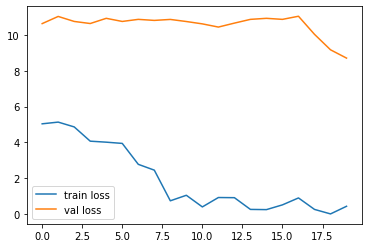

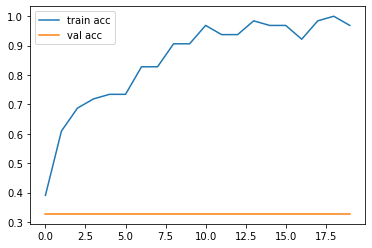

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(r.history['loss'], label='train loss');
plt.plot(r.history['val_loss'], label='val loss');
plt.legend();
plt.show();
plt.savefig('LossVal_loss');

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc');
plt.plot(r.history['val_accuracy'], label='val acc');
plt.legend();
plt.show();
plt.savefig('AccVal_acc');

In [19]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')